# **DỰ BÁO GIÁ CHỨNG KHOÁN**

Đoạn mã dưới đây bao gồm các bước sử dụng mô hình RNN đơn biến để dự báo giá chứng khoán của Công ty Cổ phần Viễn thông FPT:

1. Thu thập dữ liệu từ thư viện vnstock và tiến hành tiền xử lý dữ liệu.

2. Chuẩn bị dữ liệu huấn luyện.

3. Xây dựng mô hình RNN.

4. Tối ưu hóa tham số mô hình bằng phương pháp Bayesian.

5. Huấn luyện mô hình với tham số tối ưu.

6. Đánh giá mô hình qua các chỉ số đánh giá MSE, RMSE, MAPE, R².

7. Đánh giá kết quả thông qua biểu đồ trực quan.

#CHUẨN BỊ CÁC THƯ VIỆN

In [ ]:
!pip install vnstock
!pip install vnstock3 --upgrade
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import sys
import optuna
import seaborn as sns
np.random.seed(1)
import datetime as dt
import time
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Lấy dữ liệu từ thư viện vnstock
from vnstock import Quote

#TIỀN XỬ LÝ DỮ LIỆU

Lấy dữ liệu

In [ ]:
# Lấy dữ liệu giá cổ phiếu FPT từ vnstock
quote = Quote(symbol="FPT", source="VCI")
start_date = "2019-11-20"
end_date = "2024-11-20"
data = quote.history(start=start_date, end=end_date)

df = pd.DataFrame(data)
print(data)


           time    open    high     low   close   volume
0    2019-11-20   24.64   24.64   23.96   24.05  2291760
1    2019-11-21   24.05   24.18   23.67   23.71  3303950
2    2019-11-22   23.84   24.18   23.50   23.71  1625820
3    2019-11-25   23.75   24.13   23.62   23.96  1087990
4    2019-11-26   24.13   24.22   24.05   24.18   968690
...         ...     ...     ...     ...     ...      ...
1247 2024-11-15  134.37  134.76  131.69  132.98  6574421
1248 2024-11-18  133.08  133.67  131.59  133.08  3910975
1249 2024-11-19  132.58  132.68  129.00  129.10  7652727
1250 2024-11-20  129.10  131.49  125.83  131.49  8474055
1251 2024-11-21  131.49  132.08  130.10  132.08  3183165

[1252 rows x 6 columns]


Kiểm tra dữ liệu

In [ ]:
# Bảng thống kê mô tả của bộ dữ liệu
print("Bảng thống kê mô tả dữ liệu:")
print(df.describe())

Bảng thống kê mô tả dữ liệu:
                                time         open         high          low  \
count                           1252  1252.000000  1252.000000  1252.000000   
mean   2022-05-23 08:18:01.150159616    60.869944    61.537252    60.242899   
min              2019-11-20 00:00:00    17.150000    17.400000    16.980000   
25%              2021-02-22 18:00:00    38.487500    38.737500    37.777500   
50%              2022-05-25 12:00:00    57.270000    57.780000    56.750000   
75%              2023-08-22 06:00:00    72.862500    73.512500    71.672500   
max              2024-11-21 00:00:00   141.020000   141.810000   138.640000   
std                              NaN    31.234993    31.529763    30.945988   

             close        volume  
count  1252.000000  1.252000e+03  
mean     60.901965  2.250233e+06  
min      17.100000  2.219660e+05  
25%      38.437500  1.173650e+06  
50%      57.145000  1.830030e+06  
75%      72.900000  2.762853e+06  
max     140.72

In [ ]:
# Kiểm tra giá trị null, trùng lặp
print("Số lượng giá trị null trong dữ liệu:")
print(df.isnull().sum())
print("Số lượng bản ghi trùng lặp:", df.duplicated().sum())

Số lượng giá trị null trong dữ liệu:
time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64
Số lượng bản ghi trùng lặp: 0


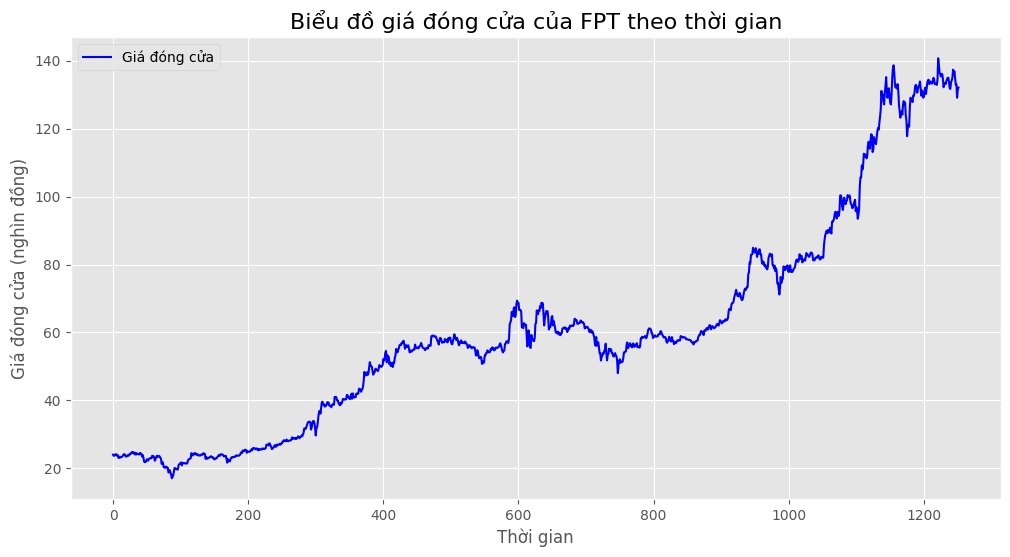

In [ ]:
# Trực quan hóa dữ liệu giá đóng cửa theo thời gian
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], color='blue', label='Giá đóng cửa')
plt.title(f'Biểu đồ giá đóng cửa của {quote.symbol} theo thời gian', fontsize=16)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá đóng cửa (nghìn đồng)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

  Variable  Correlation with Close
0     open                0.999454
1     high                0.999762
2      low                0.999697
3   volume                0.454607


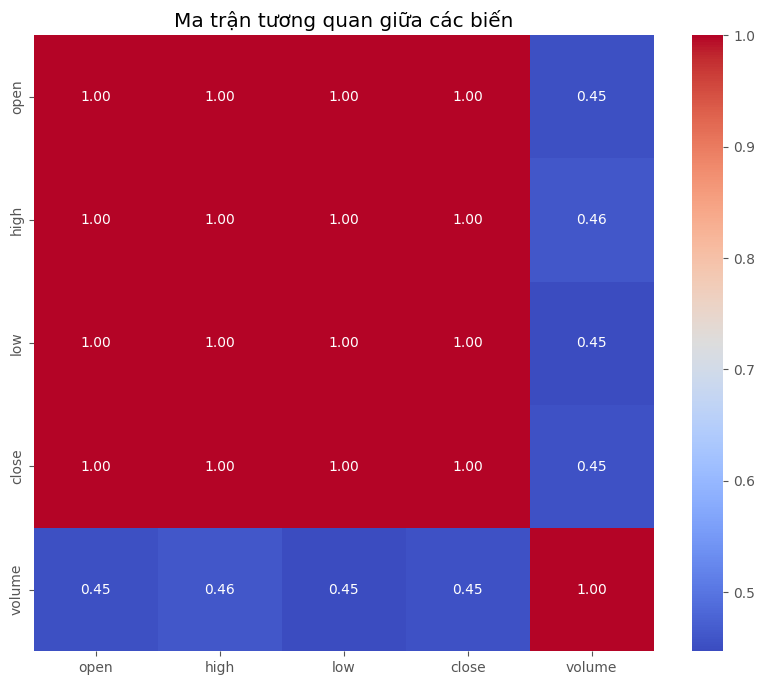

In [ ]:
# Tính toán mức độ tương quan giữa các biến
correlation_with_close = df[['open', 'high', 'low', 'close', 'volume']].corr()['close']
correlation_with_close = correlation_with_close.drop('close')

correlation_table = pd.DataFrame(correlation_with_close).reset_index()
correlation_table.columns = ['Variable', 'Correlation with Close']
print(correlation_table)

plt.figure(figsize=(10, 8))
sns.heatmap(df[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Ma trận tương quan giữa các biến')
plt.show()

Xử lý dữ liệu

In [ ]:
# Chuyển đổi dữ liệu về dạng DataFrame và xử lý
if df is not None:
    df = pd.DataFrame(df)
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
else:
    raise ValueError("Không thể lấy dữ liệu từ vnstock. Vui lòng kiểm tra kết nối hoặc mã cổ phiếu.")

# Loại bỏ các hàng có volume = 0
df.drop(df[df['volume'] == 0].index, inplace=True)

In [ ]:
# Chọn biến huấn luyện
series = df[['close']]

# Chia dữ liệu thành các tập Train, Validation và Test
train_data = series.loc["2019-11-20":"2022-11-20"].values.reshape(-1, 1)
val_data = series.loc["2022-11-21":"2023-11-20"].values.reshape(-1, 1)
test_data = series.loc["2023-11-21":"2024-11-20"].values.reshape(-1, 1)

# Chuẩn hoá dữ liệu
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

#XÂY DỰNG MÔ HÌNH

Xây dựng và huấn luyện mô hình trên tập train và validation

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80, verbose=1, mode='min')
callbacks_list = [earlystop]

def fit_model(train, val, timesteps, hl, lr, batch, epochs):
    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Chuẩn bị dữ liệu train
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Chuẩn bị dữ liệu validation
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(SimpleRNN(hl[0], input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
    for i in range(1, len(hl) - 1):
        model.add(SimpleRNN(hl[i], activation='relu', return_sequences=True))
    model.add(SimpleRNN(hl[-1], activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, validation_data=(X_val, Y_val), verbose=0, shuffle=False)
    return model, history.history['loss'], history.history['val_loss']


Đánh giá và dự đoán trên tập test

In [ ]:
def evaluate_model(model, test, timesteps):
    X_test = []
    Y_test = []

    # Chuẩn bị dữ liệu test
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Dự đoán
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

Tối ưu hoá các tham số

In [ ]:
# Tối ưu hoá các tham số bằng Bayesian Optimization
def objective(trial):
    timesteps = trial.suggest_int('timesteps', 20, 60, step=10)
    hl = [trial.suggest_int(f'hl_{i}', 20, 50, step=5) for i in range(2)]
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 50, 300, step=50)

    model, train_loss, val_loss = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)
    mse, rmse, mape, r2, _, _ = evaluate_model(model, test, timesteps)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)

[I 2025-01-03 10:57:07,945] A new study created in memory with name: no-name-21cef3a9-56f0-44e7-bdce-22592dc95505
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2025-01-03 10:58:05,254] Trial 0 finished with value: 0.003954932606355487 and parameters: {'timesteps': 40, 'hl_0': 50, 'hl_1': 40, 'lr': 0.0006756304932078206, 'batch_size': 64, 'num_epochs': 150}. Best is trial 0 with value: 0.003954932606355487.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-01-03 11:02:08,466] Trial 1 finished with value: 0.029629769793227168 and parameters: {'timesteps': 30, 'hl_0': 20, 'hl_1': 20, 'lr': 0.000142556118602388, 'batch_size': 16, 'num_epochs': 300}. Best is trial 0 with value: 0.003954932606355487.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-01-03 11:02:43,819] Trial 2 finished with value: 0.012641132754078976 and parameters: {'timesteps': 50, 'hl_0': 40, 'hl_1': 45, 'lr': 0.0005867097812389068, 'batch_size': 32, 'num_epochs': 50}. Best is trial 0 with value: 0.003954932606355487.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-03 11:04:58,626] Trial 3 finished with value: 0.014160406313267449 and parameters: {'timesteps': 50, 'hl_0': 30, 'hl_1': 40, 'lr': 0.0003459939744636865, 'batch_size': 32, 'num_epochs': 200}. Best is trial 0 with value: 0.003954932606355487.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-01-03 11:07:43,459] Trial 4 finished with value: 2.390568868467897 and parameters: {'timesteps': 20, 'hl_0': 40, 'hl_1': 20, 'lr': 0.009653427913816426, 'batch_size': 16, 'num_epochs': 250}. Best is trial 0 with value: 0.003954932606355487.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2025-01-03 11:10:22,644] Trial 5 finished with value: 0.012666508583001246 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 35, 'lr': 0.0004431836805260169, 'batch_size': 32, 'num_epochs': 250}. Best is trial 0 with value: 0.003954932606355487.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-01-03 11:11:57,097] Trial 6 finished with value: 0.00937048686289194 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 35, 'lr': 0.007961409357319567, 'batch_size': 64, 'num_epochs': 200}. Best is trial 0 with value: 0.003954932606355487.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-01-03 11:13:16,973] Trial 7 finished with value: 0.0014280149338228433 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 35, 'lr': 0.0026208314387056184, 'batch_size': 64, 'num_epochs': 300}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-01-03 11:14:56,268] Trial 8 finished with value: 0.028843212601484963 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 20, 'lr': 0.0028920174190028543, 'batch_size': 16, 'num_epochs': 150}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-01-03 11:17:35,100] Trial 9 finished with value: 0.009928226221021089 and parameters: {'timesteps': 40, 'hl_0': 50, 'hl_1': 20, 'lr': 0.0001436476015356357, 'batch_size': 32, 'num_epochs': 250}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-01-03 11:17:48,621] Trial 10 finished with value: 0.006071013577654599 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 30, 'lr': 0.0022240678273161125, 'batch_size': 128, 'num_epochs': 50}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-01-03 11:18:36,161] Trial 11 finished with value: 0.0034514071202491653 and parameters: {'timesteps': 30, 'hl_0': 45, 'hl_1': 50, 'lr': 0.0015388134464310766, 'batch_size': 64, 'num_epochs': 150}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-01-03 11:19:09,360] Trial 12 finished with value: 0.002920412237108999 and parameters: {'timesteps': 30, 'hl_0': 40, 'hl_1': 50, 'lr': 0.0018627950235403882, 'batch_size': 64, 'num_epochs': 100}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-01-03 11:19:35,655] Trial 13 finished with value: 0.004201366342775884 and parameters: {'timesteps': 20, 'hl_0': 35, 'hl_1': 30, 'lr': 0.004356618541769002, 'batch_size': 64, 'num_epochs': 100}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-03 11:20:09,633] Trial 14 finished with value: 0.008656773547445281 and parameters: {'timesteps': 30, 'hl_0': 40, 'hl_1': 50, 'lr': 0.0011580765394364465, 'batch_size': 64, 'num_epochs': 100}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2025-01-03 11:20:58,358] Trial 15 finished with value: 0.010939746872854737 and parameters: {'timesteps': 20, 'hl_0': 35, 'hl_1': 30, 'lr': 0.004709439537369918, 'batch_size': 128, 'num_epochs': 300}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[I 2025-01-03 11:21:32,849] Trial 16 finished with value: 0.002044997621524979 and parameters: {'timesteps': 30, 'hl_0': 45, 'hl_1': 45, 'lr': 0.0019728083811710907, 'batch_size': 64, 'num_epochs': 100}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-01-03 11:22:29,899] Trial 17 finished with value: 0.0021658980500623612 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 40, 'lr': 0.003987092880116212, 'batch_size': 64, 'num_epochs': 200}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2025-01-03 11:23:05,923] Trial 18 finished with value: 0.0028253102572724383 and parameters: {'timesteps': 40, 'hl_0': 45, 'hl_1': 45, 'lr': 0.0009680220817454773, 'batch_size': 64, 'num_epochs': 100}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-01-03 11:24:07,102] Trial 19 finished with value: 0.008250555503213035 and parameters: {'timesteps': 30, 'hl_0': 30, 'hl_1': 45, 'lr': 0.0029381943981523187, 'batch_size': 128, 'num_epochs': 300}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-01-03 11:24:22,003] Trial 20 finished with value: 0.016396490327948314 and parameters: {'timesteps': 20, 'hl_0': 25, 'hl_1': 25, 'lr': 0.0002550427752129403, 'batch_size': 64, 'num_epochs': 50}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-01-03 11:25:16,758] Trial 21 finished with value: 0.0034629972036421446 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 40, 'lr': 0.00526809069723355, 'batch_size': 64, 'num_epochs': 200}. Best is trial 7 with value: 0.0014280149338228433.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-01-03 11:26:26,225] Trial 22 finished with value: 0.0014178736822863395 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 40, 'lr': 0.003294599297794883, 'batch_size': 64, 'num_epochs': 250}. Best is trial 22 with value: 0.0014178736822863395.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-01-03 11:27:51,316] Trial 23 finished with value: 0.003875796033226536 and parameters: {'timesteps': 30, 'hl_0': 50, 'hl_1': 35, 'lr': 0.0012742212570489178, 'batch_size': 64, 'num_epochs': 250}. Best is trial 22 with value: 0.0014178736822863395.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-01-03 11:29:18,712] Trial 24 finished with value: 0.002368644901520151 and parameters: {'timesteps': 20, 'hl_0': 40, 'hl_1': 45, 'lr': 0.0022505470629637266, 'batch_size': 64, 'num_epochs': 300}. Best is trial 22 with value: 0.0014178736822863395.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-01-03 11:30:41,363] Trial 25 finished with value: 0.0032159378299507404 and parameters: {'timesteps': 30, 'hl_0': 45, 'hl_1': 40, 'lr': 0.0029604400101072782, 'batch_size': 64, 'num_epochs': 250}. Best is trial 22 with value: 0.0014178736822863395.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2025-01-03 11:32:03,514] Trial 26 finished with value: 0.010732818123496463 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 35, 'lr': 0.006453630725947708, 'batch_size': 64, 'num_epochs': 300}. Best is trial 22 with value: 0.0014178736822863395.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-01-03 11:32:54,393] Trial 27 finished with value: 0.007623981266809233 and parameters: {'timesteps': 30, 'hl_0': 35, 'hl_1': 45, 'lr': 0.0016739117016886915, 'batch_size': 128, 'num_epochs': 250}. Best is trial 22 with value: 0.0014178736822863395.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2025-01-03 11:38:35,789] Trial 28 finished with value: 0.00731774117923173 and parameters: {'timesteps': 40, 'hl_0': 40, 'hl_1': 35, 'lr': 0.0008632986033597113, 'batch_size': 16, 'num_epochs': 300}. Best is trial 22 with value: 0.0014178736822863395.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-01-03 11:39:20,078] Trial 29 finished with value: 0.0012828608564347936 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 40, 'lr': 0.003524635754465736, 'batch_size': 64, 'num_epochs': 150}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-01-03 11:40:04,910] Trial 30 finished with value: 0.014814584276056982 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 40, 'lr': 0.00341905851152204, 'batch_size': 64, 'num_epochs': 150}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


[I 2025-01-03 11:40:56,691] Trial 31 finished with value: 0.003049441247998334 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 40, 'lr': 0.002226704984880062, 'batch_size': 64, 'num_epochs': 150}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-01-03 11:41:28,774] Trial 32 finished with value: 0.002236272115335041 and parameters: {'timesteps': 20, 'hl_0': 45, 'hl_1': 45, 'lr': 0.0063723615607389665, 'batch_size': 64, 'num_epochs': 100}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-01-03 11:42:31,984] Trial 33 finished with value: 0.003622750915915045 and parameters: {'timesteps': 30, 'hl_0': 45, 'hl_1': 40, 'lr': 0.0007347092967363927, 'batch_size': 64, 'num_epochs': 200}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-01-03 11:43:18,074] Trial 34 finished with value: 0.0015069068301866908 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 30, 'lr': 0.0013741577243944925, 'batch_size': 64, 'num_epochs': 150}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-01-03 11:46:39,248] Trial 35 finished with value: 0.03181144083462792 and parameters: {'timesteps': 60, 'hl_0': 50, 'hl_1': 25, 'lr': 0.0015429720297547892, 'batch_size': 16, 'num_epochs': 150}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-01-03 11:47:48,884] Trial 36 finished with value: 0.15737200395630066 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 30, 'lr': 0.0033374099242826933, 'batch_size': 32, 'num_epochs': 200}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-03 11:48:59,321] Trial 37 finished with value: 0.006657338490637968 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 30, 'lr': 0.0005709902153623613, 'batch_size': 64, 'num_epochs': 250}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-01-03 11:50:37,389] Trial 38 finished with value: 0.011299395503193031 and parameters: {'timesteps': 50, 'hl_0': 40, 'hl_1': 25, 'lr': 0.0012160115679466011, 'batch_size': 32, 'num_epochs': 150}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-01-03 11:52:46,395] Trial 39 finished with value: 0.05293964435167699 and parameters: {'timesteps': 20, 'hl_0': 50, 'hl_1': 35, 'lr': 0.009741331094340047, 'batch_size': 16, 'num_epochs': 200}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step


[I 2025-01-03 11:54:38,712] Trial 40 finished with value: 0.001346667189632228 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 35, 'lr': 0.0025901195549148143, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2025-01-03 11:57:18,759] Trial 41 finished with value: 0.01636518394951653 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 35, 'lr': 0.0026001799562796455, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-01-03 12:00:29,498] Trial 42 finished with value: 0.0014753387654602213 and parameters: {'timesteps': 60, 'hl_0': 50, 'hl_1': 35, 'lr': 0.004009648117231733, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-01-03 12:03:04,574] Trial 43 finished with value: 0.002177316729518711 and parameters: {'timesteps': 60, 'hl_0': 45, 'hl_1': 35, 'lr': 0.005871523989930471, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-01-03 12:05:25,104] Trial 44 finished with value: 0.0031373854549237305 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 40, 'lr': 0.007462472393477268, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-01-03 12:08:05,488] Trial 45 finished with value: 0.008127264021587383 and parameters: {'timesteps': 50, 'hl_0': 20, 'hl_1': 35, 'lr': 0.0038962762409276135, 'batch_size': 32, 'num_epochs': 250}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2025-01-03 12:09:53,084] Trial 46 finished with value: 0.003006855605844466 and parameters: {'timesteps': 50, 'hl_0': 50, 'hl_1': 35, 'lr': 0.00499515468504493, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-01-03 12:11:06,726] Trial 47 finished with value: 0.012007289282530153 and parameters: {'timesteps': 50, 'hl_0': 45, 'hl_1': 40, 'lr': 0.002471126812063694, 'batch_size': 128, 'num_epochs': 250}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-01-03 12:13:19,393] Trial 48 finished with value: 0.001410440489000987 and parameters: {'timesteps': 60, 'hl_0': 40, 'hl_1': 40, 'lr': 0.003615602182462864, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-01-03 12:15:01,146] Trial 49 finished with value: 0.004388762536019449 and parameters: {'timesteps': 40, 'hl_0': 40, 'hl_1': 40, 'lr': 0.0018980251616439953, 'batch_size': 64, 'num_epochs': 300}. Best is trial 29 with value: 0.0012828608564347936.


Best params: {'timesteps': 20, 'hl_0': 50, 'hl_1': 40, 'lr': 0.003524635754465736, 'batch_size': 64, 'num_epochs': 150}


Huấn luyện mô hình với tham số tối ưu

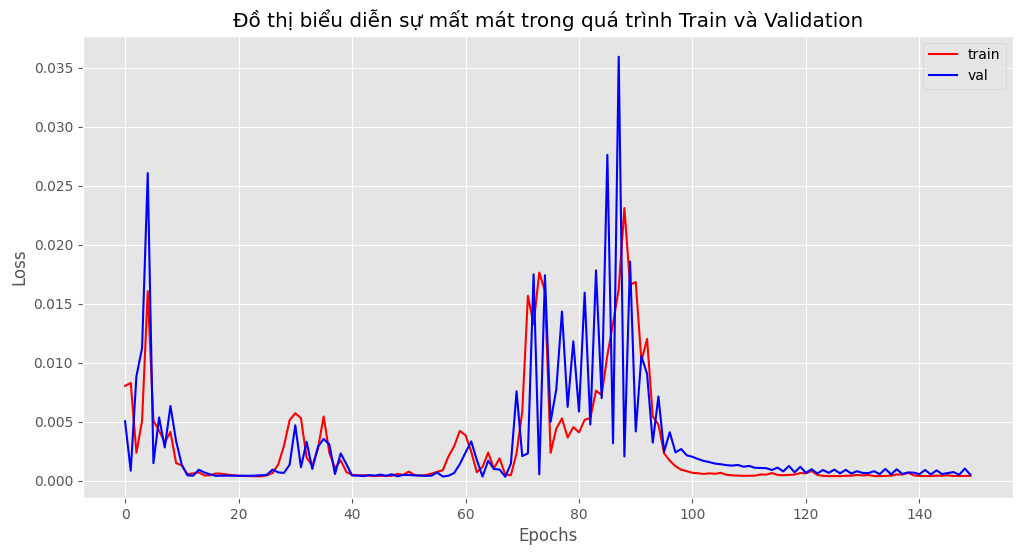

In [ ]:
timesteps = 20
hl = [50,40]
lr = 0.003524635754465736
batch_size = 64
num_epochs = 150

model, train_error, val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)

# Đồ thị biểu diễn sự mất mát trong quá trình huấn luyện và kiểm tra
def plot_error(train_loss, val_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Đồ thị biểu diễn sự mất mát trong quá trình Train và Validation')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()
plot_error(train_error, val_error)

#ĐÁNH GIÁ KẾT QUẢ

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
MSE = 0.006771710043449528
RMSE = 0.08229040067619994
MAPE = 0.03635213717664725
R-Squared Score = 0.9518277772928323


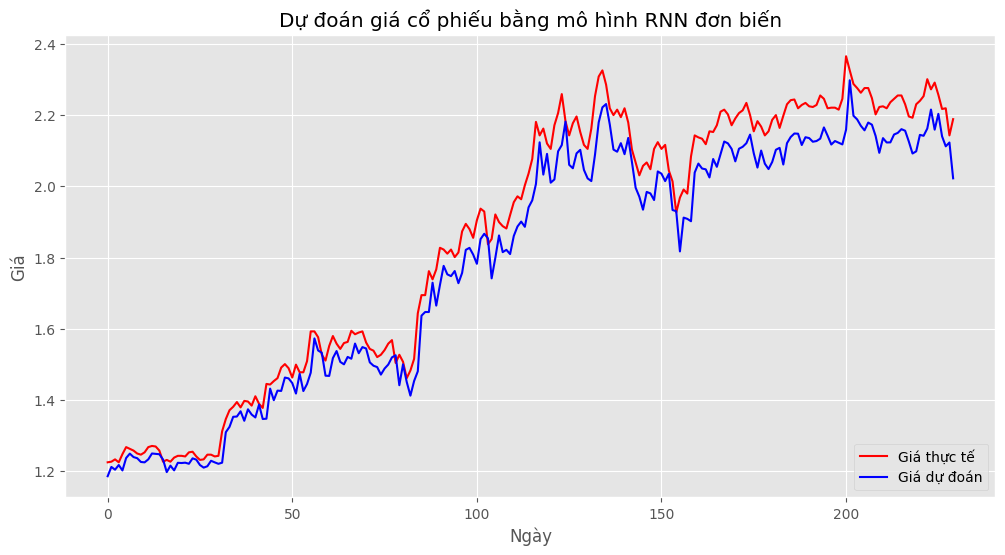

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

def plot_data(Y_test, Y_hat):
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, color='r', label='Giá thực tế')
    plt.plot(Y_hat, color='b', label='Giá dự đoán')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.title("Dự đoán giá cổ phiếu bằng mô hình RNN đơn biến")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
plot_data(true, predicted)

In [ ]:
# Tạo bảng so sánh giá trị thực tế và dự đoán
result_df = pd.DataFrame({
    'Actual': true.flatten(),
    'Predicted': predicted.flatten()
})

result_df['Giá thực tế'] = sc.inverse_transform(result_df[['Actual']])
result_df['Giá dự đoán'] = sc.inverse_transform(result_df[['Predicted']])
result_df['Chênh lệch'] = result_df['Giá thực tế'] - result_df['Giá dự đoán']
result_df = result_df.drop(columns=['Actual', 'Predicted'])

print("Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):")
print(result_df.head(16))

Bảng so sánh giá trị thực tế và dự đoán (Đơn vị: nghìn đồng):
    Giá thực tế  Giá dự đoán  Chênh lệch
0         81.13    79.087257    2.042743
1         81.22    80.451859    0.768141
2         81.56    80.046516    1.513484
3         81.13    80.728592    0.401408
4         82.33    79.934563    2.395437
5         83.36    81.761452    1.598548
6         83.11    82.403206    0.706794
7         82.85    81.899895    0.950105
8         82.42    81.731552    0.688448
9         82.25    81.179398    1.070602
10        82.59    81.121460    1.468540
11        83.36    81.562233    1.797767
12        83.53    82.422722    1.107278
13        83.45    82.372620    1.077380
14        82.85    82.313721    0.536279
15        81.22    81.535271   -0.315271
